# Import Necessary Packages

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import h5py
from sklearn.model_selection import train_test_split
from keras.layers import Dense,Dropout
from keras.models import Sequential
from keras.regularizers import l2
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
import seaborn as sns
from keras.models import load_model

# Data handling

Here are all of the data we are using for this project:


Note that these data are supposed to be GLOBAL VARIABLES!!!

In [3]:
data_dir = 'C:/Users/admin/Documents/JupyterNotebook/ICP/Project/mens-machine-learning-competition-2019/Stage2DataFiles/'
df_tour = pd.read_csv(data_dir + '/NCAATourneyDetailedResults.csv')
df_reg_season = pd.read_csv(data_dir + "/RegularSeasonDetailedResults.csv")
df_teams = pd.read_csv(data_dir + "/Teams.csv")
df_tour_comp = pd.read_csv(data_dir + '/NCAATourneyCompactResults.csv')
df_team_conferences = pd.read_csv(data_dir + '/TeamConferences.csv')
df_conferences = pd.read_csv(data_dir + '/Conferences.csv')

We call a couple of functions to see what the dataset looks like

In [4]:
df_tour.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,134,1421,92,1411,84,N,1,32,69,...,31,14,31,17,28,16,15,5,0,22
1,2003,136,1112,80,1436,51,N,0,31,66,...,16,7,7,8,26,12,17,10,3,15
2,2003,136,1113,84,1272,71,N,0,31,59,...,28,14,21,20,22,11,12,2,5,18
3,2003,136,1141,79,1166,73,N,0,29,53,...,17,12,17,14,17,20,21,6,6,21
4,2003,136,1143,76,1301,74,N,1,27,64,...,21,15,20,10,26,16,14,5,8,19


In [5]:
df_reg_season.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14


In [6]:
df_teams.head()

,TeamID,TeamName,FirstD1Season,LastD1Season
0,1101,Abilene Chr,2014,2019
1,1102,Air Force,1985,2019
2,1103,Akron,1985,2019
3,1104,Alabama,1985,2019
4,1105,Alabama A&M,2000,2019


In [7]:
df_tour_comp.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0


In [8]:
df_team_conferences.head()

,Season,TeamID,ConfAbbrev
0,1985,1114,a_sun
1,1985,1147,a_sun
2,1985,1204,a_sun
3,1985,1209,a_sun
4,1985,1215,a_sun


In [9]:
df_conferences.head()

,ConfAbbrev,Description
0,a_sun,Atlantic Sun Conference
1,a_ten,Atlantic 10 Conference
2,aac,American Athletic Conference
3,acc,Atlantic Coast Conference
4,aec,America East Conference


## Data Cleaning

We clean up the dataset by joining them according to some primary keys. Specifically, This combines the complete information of teams, conferences and matchups.

This is done using database managment techniques.

In [10]:
# This function merges the dataframe of matchups with dataframes containing team info and conference info
# @param:   a dataframe of matchups containing teamID for both teams, ConfAbbrev
# @return:  a dataframe containing Team names and conference Names 
def joinByID(df):
    df_teams_temp = df_teams.drop(['FirstD1Season', 'LastD1Season'], axis=1)
    df_new = pd.merge(df,df_teams_temp ,how='left', left_on = 'WTeamID', right_on = 'TeamID')
    df_new = df_new.drop(['TeamID'], axis=1)
    df_new = df_new.rename(columns={"TeamName": "WinningTeamName"})
    df_new = pd.merge(df_new,df_teams_temp ,how='left', left_on = 'LTeamID', right_on = 'TeamID')
    df_new = df_new.drop(['TeamID'], axis=1)
    df_new = df_new.rename(columns={"TeamName": "LosingTeamName"})
    df_conf = pd.merge(df_team_conferences,df_conferences,how='left',left_on = 'ConfAbbrev', right_on = 'ConfAbbrev')
    df_conf = df_conf.drop(['ConfAbbrev'], axis=1)
    df_new = pd.merge(df_new,df_conf,how = 'left',left_on = ['Season','WTeamID'], right_on = ['Season','TeamID'])
    df_new = df_new.drop(['TeamID'], axis=1)
    df_new = df_new.rename(columns={"Description": "WinningTeamConference"}) 
    df_new = pd.merge(df_new,df_conf,how = 'left',left_on = ['Season','LTeamID'], right_on = ['Season','TeamID'])
    df_new = df_new.drop(['TeamID'], axis=1)
    df_new = df_new.rename(columns={"Description": "LosingTeamConference"})
    return df_new
    


In [11]:
# Three global variables
df_tour_joined = joinByID(df_tour)
df_reg_season_joined = joinByID(df_reg_season)
df_tour_comp_joined = joinByID(df_tour_comp)

# Some visualization

Here we want to know some specific details about the finals: We plot the Champions and Second Places according to Teams and Conferences.

As expected, Duke stood out as the strongest team, and the Atlantic Coast Conference turned out to be the best.

In [12]:
# The final match 
df_final = df_tour_comp_joined.loc[df_tour_comp_joined.DayNum == 154]

In [13]:
# This function plots barplots of occurrences of champions and seconds
# @param:   the dataframe of the final match
# @return:  
def plotByTeams(df_final):
    winning = df_final.groupby('WinningTeamName').count()['WTeamID'].sort_values(ascending = False)
    losing = df_final.groupby('LosingTeamName').count()['LTeamID'].sort_values(ascending = False)
    X1 = winning.index.values
    Y1 = winning
    X2 = losing.index.values
    Y2 = losing
    import seaborn as sns
    sns.set(style="whitegrid")
    f, ax = plt.subplots(1,2,figsize=(8, 10))
    sns.set_color_codes("pastel")
    sns.barplot(x=Y1, y=X1,
                label="Wins", color="b",ax = ax[0])
    sns.set_color_codes("muted")
    sns.barplot(x=Y2, y=X2,
                label="Loses", color="b",ax = ax[1])

    # Add a legend and informative axis label
    ax[0].legend(ncol=2, loc="lower right", frameon=True)
    ax[0].set(xlim=(0, 6), ylabel="",
           xlabel="Plot of Champions")
    ax[1].legend(ncol=2, loc="lower right", frameon=True)
    ax[1].set(xlim=(0, 6), ylabel="",
           xlabel="Plot of Second Placess")
    sns.despine(left=True, bottom=True)
    return

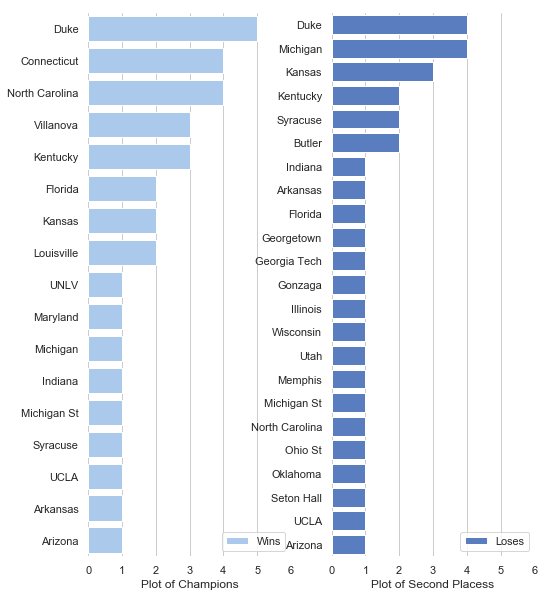

In [14]:
plotByTeams(df_final)

In [15]:
# This function plots barplots of occurrences of champions and seconds, conference-wises
# @param:   the dataframe of the final match
# @return: 
def plotByConfs(df_final):
    winning = df_final.groupby('WinningTeamConference').count()['WTeamID'].sort_values(ascending = False)
    losing = df_final.groupby('LosingTeamConference').count()['LTeamID'].sort_values(ascending = False)
    X1 = winning.index.values
    Y1 = winning
    X2 = losing.index.values
    Y2 = losing
    import seaborn as sns
    sns.set(style="whitegrid")
    f, ax = plt.subplots(1,2,figsize=(8, 10))
    sns.set_color_codes("pastel")
    sns.barplot(x=Y1, y=X1,
                label="Wins", color="b",ax = ax[0])
    sns.set_color_codes("muted")
    sns.barplot(x=Y2, y=X2,
                label="Loses", color="b",ax = ax[1])

    # Add a legend and informative axis label
    ax[0].legend(ncol=2, loc="lower right", frameon=True)
    ax[0].set(xlim=(0, 6), ylabel="",
           xlabel="Plot of Champions")
    ax[1].legend(ncol=2, loc="lower right", frameon=True)
    ax[1].set(xlim=(0, 6), ylabel="",
           xlabel="Plot of Second Placess")
    sns.despine(left=True, bottom=True)
    return

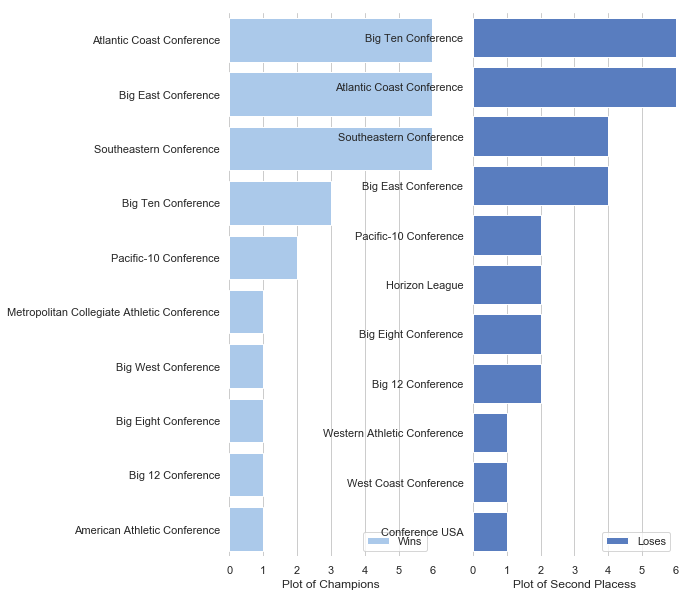

In [16]:
plotByConfs(df_final)

We then attempt to illustrate the correlation between features by plotting them out

In [17]:
# Data for correlation inspection
data_reg_season = df_reg_season_joined[['WScore','LScore','WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF']]

In [18]:
# This function plots the heatmap of the correlation matrix.
# @param:   the dataframe of regular season, all features.
# @return: 
def plotCorrelation(data):
    corr = data.corr()
    sns.set(style="white")

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    return

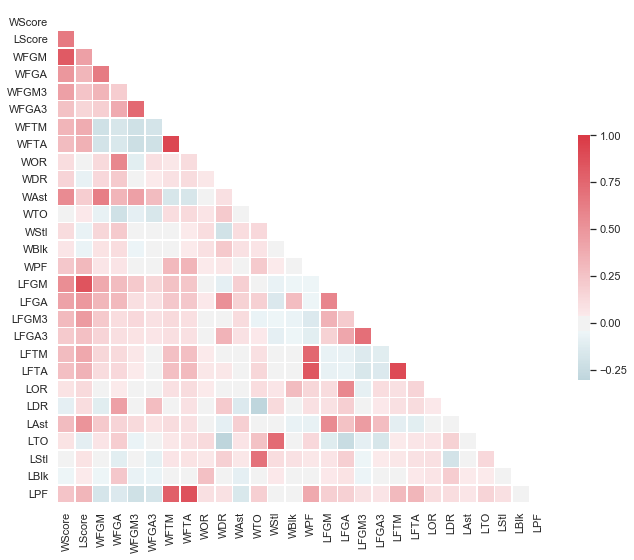

In [19]:
plotCorrelation(data_reg_season)

With this chart, we can infer that a team's score is based on their offensive power(mainly: FGM(Field Goals Made) and FGA(Field Goals Attempted)). Also it is most likely that the offensive power is negatively correlated with the opposing team's offensive power.

# Modeling

Given the variety of features, I decided to use a two-layered neural network, with two hidden layers of 100 nodes with relu activation function. And because we are doing classification, the final node uses a sigmoid. 

The data I used is the regular season matchup data, each match is represented as a 26 dimensional vector, each team composing of 13 features. And the matrix X is derived from stacking all matchups. Then, we do a train-test split: Train on 157507 samples, validate on 17501 samples

To prevent over-fitting, at each epoch 30% of random nodes are dropped. Also for inputs we use l2 regularization.

In [20]:
# This function generates training data (X,y)
# The data used are regular season data (GLOBAL VARIABLE)
# @param:   
# @return:  tuple: (X,y) for training. need to manually use y.ravel() in training step.
def getTrainingData():
    df_match_data1 = df_reg_season_joined[['WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF']]
    df_match_data2 = df_reg_season_joined[[ 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF','WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]
    matrixData1 = np.matrix(df_match_data1)
    matrixData2 = np.matrix(df_match_data2)
    matrixData = np.concatenate((matrixData1, matrixData2), axis=0)
    #print(matrixData.shape)
    y = np.concatenate((np.ones((matrixData1.shape[0],1)),np.zeros((matrixData2.shape[0],1))),axis = 0)
    #print(y.shape)
    return matrixData,y

In [21]:
# This function creates a sequential model as described: two layers, 100 'relu' nodes with l2 regularization, 0.3 dropout.
# @param:  X: the matrix of all features
#          y: the binary variable of results(0/1)
#          path: to save the model, provide a string of absolute path
# @return: 
def createModel(X,y,path):
    #defifne a sequentail Model
    model = Sequential()
    #Hidden Layer-1
    model.add(Dense(100,activation='relu',input_dim = X.shape[1],kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3, noise_shape=None, seed=None))

    #Hidden Layer-2
    model.add(Dense(100,activation = 'relu',kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3, noise_shape=None, seed=None))

    #Output layer
    model.add(Dense(1,activation='sigmoid'))

    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    print(model.summary())
    
    #train-test split
    x_train, x_test, y_train, y_test = train_test_split(X,y.ravel(),test_size=0.10)
    print('Shapes: x_train:',x_train.shape,'y_train:',y_train.shape,'x_test:',x_test.shape,'y_test',y_test.shape,sep= ' ')
    model_output = model.fit(x_train,y_train,epochs=100,batch_size=10,verbose=1,validation_data=(x_test,y_test),)
    print('Training Accuracy: ',np.mean(model_output.history['acc'] ))
    print('Validation Accuracy: ',np.mean(model_output.history['val_acc'] ))
     
    model.save(path)
    return 
    

For the data we wish to predict, we need to compose a (1,26) vector, with the first 13 features belonging to the first team and the second 13 belonging to the second team. To do so, we first calculate the average of all teams for all their 13 features.

In [22]:
# This function gets the average of every feature of every team
# @param:  
# @return: dataframe: Columns: Averages of each feature; Rows: team name
def getAverage():
    df_winning_teams = df_reg_season_joined[['WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
            'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'WinningTeamName']]
    df_losing_teams = df_reg_season_joined[['LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR',
            'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 'LosingTeamName',]]
    columnDictWin = dict()
    columnDictLosing = dict()
    
    list1 = ['WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
            'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'WinningTeamName']
    list2 = ['LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR',
            'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 'LosingTeamName',]
    list3 = ['FGM', 'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA', 'OR', 'DR',
            'Ast', 'TO', 'Stl', 'Blk', 'PF', 'TeamName',]
    for i in range(len(list1)):
        columnDictWin[list1[i]] = list3[i]
        columnDictLosing[list2[i]] = list3[i]
        
    df_losing_teams = df_losing_teams.rename(columns= columnDictLosing)
    df_winning_teams = df_winning_teams.rename(columns= columnDictWin)
    df = pd.concat([df_winning_teams,df_losing_teams], axis = 0)
    df = df.groupby('TeamName').mean()
    return df

In [23]:
df_average = getAverage()

In [24]:
df_average.head()

,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF
TeamName,,,,,,,,,,,,,
Abilene Chr,23.598726,53.828025,6.942675,19.012739,13.407643,18.929936,8.382166,21.961783,12.923567,13.535032,6.808917,2.363057,21.089172
Air Force,21.900000,48.726531,7.479592,20.851020,12.195918,17.475510,7.210204,21.110204,13.679592,12.126531,6.248980,2.046939,17.416327
Akron,24.828678,56.039106,7.925512,22.184358,13.983240,20.430168,11.102421,23.271881,13.869646,12.888268,6.588454,3.471136,18.929236
Alabama,24.458647,55.062030,6.133459,18.110902,14.593985,21.142857,11.578947,24.618421,12.142857,13.268797,6.644737,4.486842,17.622180
Alabama A&M,22.378788,56.279221,5.504329,18.162338,14.153680,21.636364,11.774892,23.090909,11.645022,15.376623,6.917749,3.558442,19.616883


Here I would provide a file containing all team names. You may refer to the txt file for test cases.

In [36]:
# This function generates a txt file containing all team names
# @param:  
# @return: 
def getTeamNames():
    fp = open('C:/Users/admin/Documents/JupyterNotebook/ICP/Project/mens-machine-learning-competition-2019/Stage2DataFiles/teamNames.txt','w')
    iterable = list(df_average.index)
    for i in iterable:
        print(i,file = fp)
    fp.close()
    return

In [37]:
getTeamNames()

# User Interface

And here we ahve the user Interface components. 

In [25]:
# This function gets the average of every feature of two teams in one 'imaginary' matchup
# @param:  tuple(Team1,Team2) of both teams' name
# @return: a (1,26) maxtrix with both team information
def getInput(Team1,Team2):
    team1Avg = np.matrix(df_average.loc[Team1])
    team2Avg = np.matrix(df_average.loc[Team2])
    modelInput = np.concatenate((team1Avg ,team2Avg), axis = 1)
    return modelInput

In [26]:
# This function calls the user interface. It first trys to locate a model. If not found, it fits a model and store it locally as model.h5
# and then loads it
# Then it askes the user to input two team names, if entered correctly, it uses the model to predict and prints the result
# @param:  
# @return: 
def userInterface():
    path = 'C:/Users/admin/Documents/JupyterNotebook/ICP/Project/mens-machine-learning-competition-2019/Stage2DataFiles/Model.h5'

    try:
        model = load_model(path)
    except:
        data = getTrainingData()
        createModel(data[0],data[1],path)
        model = load_model(path)
    while True:
        Team1 = input('Please Enter the first team name: ')
        Team2 = input('Please Enter the second team name: ')
        try:
            model = load_model(path)
            y = model.predict(getInput(Team1,Team2))
        except:
            continue
        break
    print("Estimated sigmoid output: ",y[0][0])
    if y[0][0] >= 0.5:
        print(Team1, 'is predicted to win.',sep = ' ')
    elif y[0][0] <= 0.5:
        print(Team2, 'is predicted to win.',sep = ' ')
    else:
        print('An error has occurred!')
        
    return
        

# Calling the user interface

This is where our main executable is. It does the following:

1. load the local trained model in .h5 file. If not found, train the model and store it as 'model.h5'

2. ask the user to input the name of two teams. If both are correct, return a sigmoid output and print out the prediction

The following is the training output of my model:

In [27]:
# Layer (type)                 Output Shape              Param #   
# =================================================================
# dense_19 (Dense)             (None, 100)               2700      
# _________________________________________________________________
# dropout_13 (Dropout)         (None, 100)               0         
# _________________________________________________________________
# dense_20 (Dense)             (None, 100)               10100     
# _________________________________________________________________
# dropout_14 (Dropout)         (None, 100)               0         
# _________________________________________________________________
# dense_21 (Dense)             (None, 1)                 101       
# =================================================================
# Total params: 12,901
# Trainable params: 12,901
# Non-trainable params: 0
# _________________________________________________________________
# None
# Shapes: x_train: (157507, 26) y_train: (157507,) x_test: (17501, 26) y_test (17501,)
# Train on 157507 samples, validate on 17501 samples
# Epoch 1/100
# 157507/157507 [==============================] - 25s 158us/step - loss: 0.2848 - acc: 0.9423 - val_loss: 0.1069 - val_acc: 0.9768
# Epoch 2/100
# 157507/157507 [==============================] - 20s 124us/step - loss: 0.1350 - acc: 0.9619 - val_loss: 0.0876 - val_acc: 0.9830
# Epoch 3/100
# 157507/157507 [==============================] - 18s 116us/step - loss: 0.1279 - acc: 0.9635 - val_loss: 0.0902 - val_acc: 0.9814
# Epoch 4/100
# 157507/157507 [==============================] - 18s 117us/step - loss: 0.1287 - acc: 0.9620 - val_loss: 0.0773 - val_acc: 0.9858
# Epoch 5/100
# 157507/157507 [==============================] - 19s 122us/step - loss: 0.1257 - acc: 0.9664 - val_loss: 0.0789 - val_acc: 0.9847
# Epoch 6/100
# 157507/157507 [==============================] - 21s 131us/step - loss: 0.1257 - acc: 0.9671 - val_loss: 0.0619 - val_acc: 0.9934
# Epoch 7/100
# 157507/157507 [==============================] - 19s 122us/step - loss: 0.1252 - acc: 0.9672 - val_loss: 0.1345 - val_acc: 0.9574
# Epoch 8/100
# 157507/157507 [==============================] - 21s 132us/step - loss: 0.1263 - acc: 0.9673 - val_loss: 0.0688 - val_acc: 0.9944
# Epoch 9/100
# 157507/157507 [==============================] - 19s 121us/step - loss: 0.1225 - acc: 0.9689 - val_loss: 0.1403 - val_acc: 0.9566
# Epoch 10/100
# 157507/157507 [==============================] - 20s 125us/step - loss: 0.1307 - acc: 0.9659 - val_loss: 0.0716 - val_acc: 0.9913
# Epoch 11/100
# 157507/157507 [==============================] - 20s 127us/step - loss: 0.1247 - acc: 0.9690 - val_loss: 0.0636 - val_acc: 0.9933
# Epoch 12/100
# 157507/157507 [==============================] - 20s 125us/step - loss: 0.1257 - acc: 0.9693 - val_loss: 0.0761 - val_acc: 0.9865
# Epoch 13/100
# 157507/157507 [==============================] - 19s 121us/step - loss: 0.1292 - acc: 0.9685 - val_loss: 0.1361 - val_acc: 0.9652
# Epoch 14/100
# 157507/157507 [==============================] - 19s 122us/step - loss: 0.1250 - acc: 0.9706 - val_loss: 0.0815 - val_acc: 0.9833
# Epoch 15/100
# 157507/157507 [==============================] - 19s 121us/step - loss: 0.1249 - acc: 0.9704 - val_loss: 0.0599 - val_acc: 0.9952
# Epoch 16/100
# 157507/157507 [==============================] - 19s 122us/step - loss: 0.1249 - acc: 0.9713 - val_loss: 0.0994 - val_acc: 0.9771
# Epoch 17/100
# 157507/157507 [==============================] - 19s 121us/step - loss: 0.1254 - acc: 0.9718 - val_loss: 0.0520 - val_acc: 0.9961
# Epoch 18/100
# 157507/157507 [==============================] - 19s 121us/step - loss: 0.1237 - acc: 0.9730 - val_loss: 0.0629 - val_acc: 0.9929
# Epoch 19/100
# 157507/157507 [==============================] - 19s 121us/step - loss: 0.1227 - acc: 0.9735 - val_loss: 0.0695 - val_acc: 0.9966
# Epoch 20/100
# 157507/157507 [==============================] - 19s 121us/step - loss: 0.1250 - acc: 0.9732 - val_loss: 0.0628 - val_acc: 0.9955
# Epoch 21/100
# 157507/157507 [==============================] - 19s 121us/step - loss: 0.1231 - acc: 0.9737 - val_loss: 0.0720 - val_acc: 0.9919
# Epoch 22/100
# 157507/157507 [==============================] - 19s 121us/step - loss: 0.1236 - acc: 0.9740 - val_loss: 0.0734 - val_acc: 0.9913
# Epoch 23/100
# 157507/157507 [==============================] - 19s 121us/step - loss: 0.1225 - acc: 0.9740 - val_loss: 0.0665 - val_acc: 0.9965
# Epoch 24/100
# 157507/157507 [==============================] - 19s 121us/step - loss: 0.1287 - acc: 0.9729 - val_loss: 0.0649 - val_acc: 0.9969
# Epoch 25/100
# 157507/157507 [==============================] - 19s 121us/step - loss: 0.1227 - acc: 0.9742 - val_loss: 0.1085 - val_acc: 0.9699
# Epoch 26/100
# 157507/157507 [==============================] - 19s 121us/step - loss: 0.1275 - acc: 0.9731 - val_loss: 0.0737 - val_acc: 0.9915
# Epoch 27/100
# 157507/157507 [==============================] - 19s 121us/step - loss: 0.1263 - acc: 0.9728 - val_loss: 0.0740 - val_acc: 0.9929
# Epoch 28/100
# 157507/157507 [==============================] - 19s 121us/step - loss: 0.1219 - acc: 0.9740 - val_loss: 0.0650 - val_acc: 0.9967
# Epoch 29/100
# 157507/157507 [==============================] - 19s 121us/step - loss: 0.1269 - acc: 0.9732 - val_loss: 0.0646 - val_acc: 0.9974
# Epoch 30/100
# 157507/157507 [==============================] - 19s 121us/step - loss: 0.1247 - acc: 0.9739 - val_loss: 0.0710 - val_acc: 0.9961
# Epoch 31/100
# 157507/157507 [==============================] - 19s 121us/step - loss: 0.1233 - acc: 0.9736 - val_loss: 0.0731 - val_acc: 0.9910
# Epoch 32/100
# 157507/157507 [==============================] - 19s 122us/step - loss: 0.1262 - acc: 0.9731 - val_loss: 0.0795 - val_acc: 0.9858
# Epoch 33/100
# 157507/157507 [==============================] - 19s 121us/step - loss: 0.1220 - acc: 0.9741 - val_loss: 0.1127 - val_acc: 0.9685
# Epoch 34/100
# 157507/157507 [==============================] - 19s 121us/step - loss: 0.1243 - acc: 0.9738 - val_loss: 0.1144 - val_acc: 0.9688
# Epoch 35/100
# 157507/157507 [==============================] - 19s 121us/step - loss: 0.1243 - acc: 0.9733 - val_loss: 0.0652 - val_acc: 0.9963
# Epoch 36/100
# 157507/157507 [==============================] - 19s 121us/step - loss: 0.1267 - acc: 0.9729 - val_loss: 0.1060 - val_acc: 0.9715
# Epoch 37/100
# 157507/157507 [==============================] - 19s 122us/step - loss: 0.1289 - acc: 0.9724 - val_loss: 0.0652 - val_acc: 0.9969
# Epoch 38/100
# 157507/157507 [==============================] - 19s 121us/step - loss: 0.1250 - acc: 0.9736 - val_loss: 0.1824 - val_acc: 0.9449
# Epoch 39/100
# 157507/157507 [==============================] - 19s 121us/step - loss: 0.1252 - acc: 0.9736 - val_loss: 0.0563 - val_acc: 0.9968
# Epoch 40/100
# 157507/157507 [==============================] - 19s 121us/step - loss: 0.1267 - acc: 0.9731 - val_loss: 0.0627 - val_acc: 0.9962
# Epoch 41/100
# 157507/157507 [==============================] - 19s 121us/step - loss: 0.1311 - acc: 0.9716 - val_loss: 0.0801 - val_acc: 0.9912
# Epoch 42/100
# 157507/157507 [==============================] - 19s 122us/step - loss: 0.1292 - acc: 0.9727 - val_loss: 0.0809 - val_acc: 0.9850
# Epoch 43/100
# 157507/157507 [==============================] - 19s 119us/step - loss: 0.1254 - acc: 0.9735 - val_loss: 0.0739 - val_acc: 0.9905
# Epoch 44/100
# 157507/157507 [==============================] - 19s 120us/step - loss: 0.1259 - acc: 0.9729 - val_loss: 0.0923 - val_acc: 0.9762
# Epoch 45/100
# 157507/157507 [==============================] - 19s 119us/step - loss: 0.1274 - acc: 0.9723 - val_loss: 0.0603 - val_acc: 0.9966
# Epoch 46/100
# 157507/157507 [==============================] - 19s 119us/step - loss: 0.1287 - acc: 0.9724 - val_loss: 0.0632 - val_acc: 0.9955
# Epoch 47/100
# 157507/157507 [==============================] - 19s 119us/step - loss: 0.1263 - acc: 0.9731 - val_loss: 0.1004 - val_acc: 0.9745
# Epoch 48/100
# 157507/157507 [==============================] - 19s 120us/step - loss: 0.1303 - acc: 0.9721 - val_loss: 0.0993 - val_acc: 0.9767
# Epoch 49/100
# 157507/157507 [==============================] - 19s 119us/step - loss: 0.1292 - acc: 0.9726 - val_loss: 0.0726 - val_acc: 0.9951
# Epoch 50/100
# 
# 157507/157507 [==============================] - 19s 117us/step - loss: 0.1317 - acc: 0.9719 - val_loss: 0.0693 - val_acc: 0.9929
# Epoch 51/100
# 157507/157507 [==============================] - 18s 117us/step - loss: 0.1297 - acc: 0.9725 - val_loss: 0.0753 - val_acc: 0.9956
# Epoch 52/100
# 157507/157507 [==============================] - 18s 117us/step - loss: 0.1298 - acc: 0.9721 - val_loss: 0.0696 - val_acc: 0.9943
# Epoch 53/100
# 157507/157507 [==============================] - 19s 118us/step - loss: 0.1262 - acc: 0.9734 - val_loss: 0.0664 - val_acc: 0.9951
# Epoch 54/100
# 157507/157507 [==============================] - 19s 118us/step - loss: 0.1314 - acc: 0.9717 - val_loss: 0.0954 - val_acc: 0.9802
# Epoch 55/100
# 157507/157507 [==============================] - 19s 118us/step - loss: 0.1285 - acc: 0.9729 - val_loss: 0.0719 - val_acc: 0.9934
# Epoch 56/100
# 157507/157507 [==============================] - 18s 117us/step - loss: 0.1313 - acc: 0.9722 - val_loss: 0.0672 - val_acc: 0.9974
# Epoch 57/100
# 157507/157507 [==============================] - 19s 117us/step - loss: 0.1349 - acc: 0.9710 - val_loss: 0.0708 - val_acc: 0.9954
# Epoch 58/100
# 157507/157507 [==============================] - 19s 118us/step - loss: 0.1316 - acc: 0.9721 - val_loss: 0.0807 - val_acc: 0.9919
# Epoch 59/100
# 157507/157507 [==============================] - 18s 117us/step - loss: 0.1358 - acc: 0.9710 - val_loss: 0.0782 - val_acc: 0.9905
# Epoch 60/100
# 157507/157507 [==============================] - 19s 118us/step - loss: 0.1308 - acc: 0.9726 - val_loss: 0.0657 - val_acc: 0.9970
# Epoch 61/100
# 157507/157507 [==============================] - 18s 117us/step - loss: 0.1314 - acc: 0.9723 - val_loss: 0.1155 - val_acc: 0.9713
# Epoch 62/100
# 157507/157507 [==============================] - 18s 117us/step - loss: 0.1322 - acc: 0.9717 - val_loss: 0.0844 - val_acc: 0.9868
# Epoch 63/100
# 157507/157507 [==============================] - 18s 117us/step - loss: 0.1353 - acc: 0.9712 - val_loss: 0.0764 - val_acc: 0.9939
# Epoch 64/100
# 157507/157507 [==============================] - 18s 117us/step - loss: 0.1315 - acc: 0.9725 - val_loss: 0.0911 - val_acc: 0.9898
# Epoch 65/100
# 157507/157507 [==============================] - 18s 117us/step - loss: 0.1350 - acc: 0.9716 - val_loss: 0.0884 - val_acc: 0.9819
# Epoch 66/100
# 157507/157507 [==============================] - 19s 118us/step - loss: 0.1318 - acc: 0.9725 - val_loss: 0.0626 - val_acc: 0.9990
# Epoch 67/100
# 157507/157507 [==============================] - 19s 118us/step - loss: 0.1310 - acc: 0.9725 - val_loss: 0.0684 - val_acc: 0.9961
# Epoch 68/100
# 157507/157507 [==============================] - 19s 118us/step - loss: 0.1370 - acc: 0.9710 - val_loss: 0.0738 - val_acc: 0.9953
# Epoch 69/100
# 157507/157507 [==============================] - 19s 117us/step - loss: 0.1293 - acc: 0.9732 - val_loss: 0.0621 - val_acc: 0.9975
# Epoch 70/100
# 157507/157507 [==============================] - 18s 117us/step - loss: 0.1300 - acc: 0.9722 - val_loss: 0.1574 - val_acc: 0.9546
# Epoch 71/100
# 157507/157507 [==============================] - 18s 117us/step - loss: 0.1358 - acc: 0.9710 - val_loss: 0.0709 - val_acc: 0.9942
# Epoch 72/100
# 157507/157507 [==============================] - 18s 117us/step - loss: 0.1318 - acc: 0.9719 - val_loss: 0.0786 - val_acc: 0.9938
# Epoch 73/100
# 157507/157507 [==============================] - 19s 119us/step - loss: 0.1302 - acc: 0.9724 - val_loss: 0.0899 - val_acc: 0.9844
# Epoch 74/100
# 157507/157507 [==============================] - 18s 117us/step - loss: 0.1321 - acc: 0.9720 - val_loss: 0.0633 - val_acc: 0.9971
# Epoch 75/100
# 157507/157507 [==============================] - 19s 118us/step - loss: 0.1326 - acc: 0.9722 - val_loss: 0.0602 - val_acc: 0.9988
# Epoch 76/100
# 157507/157507 [==============================] - 19s 118us/step - loss: 0.1367 - acc: 0.9706 - val_loss: 0.1133 - val_acc: 0.9719
# Epoch 77/100
# 157507/157507 [==============================] - 19s 118us/step - loss: 0.1355 - acc: 0.9710 - val_loss: 0.1601 - val_acc: 0.9649
# Epoch 78/100
# 157507/157507 [==============================] - 19s 118us/step - loss: 0.1379 - acc: 0.9706 - val_loss: 0.0949 - val_acc: 0.9801
# Epoch 79/100
# 157507/157507 [==============================] - 19s 118us/step - loss: 0.1332 - acc: 0.9718 - val_loss: 0.0719 - val_acc: 0.9965
# Epoch 80/100
# 157507/157507 [==============================] - 19s 118us/step - loss: 0.1313 - acc: 0.9725 - val_loss: 0.1003 - val_acc: 0.9814
# Epoch 81/100
# 157507/157507 [==============================] - 19s 118us/step - loss: 0.1332 - acc: 0.9715 - val_loss: 0.1599 - val_acc: 0.9484
# Epoch 82/100
# 157507/157507 [==============================] - 19s 118us/step - loss: 0.1301 - acc: 0.9729 - val_loss: 0.0635 - val_acc: 0.9971
# Epoch 83/100
# 157507/157507 [==============================] - 19s 118us/step - loss: 0.1275 - acc: 0.9735 - val_loss: 0.0685 - val_acc: 0.9949
# Epoch 84/100
# 157507/157507 [==============================] - 19s 118us/step - loss: 0.1302 - acc: 0.9727 - val_loss: 0.0604 - val_acc: 0.9981
# Epoch 85/100
# 157507/157507 [==============================] - 19s 118us/step - loss: 0.1378 - acc: 0.9707 - val_loss: 0.0912 - val_acc: 0.9841
# Epoch 86/100
# 157507/157507 [==============================] - 19s 119us/step - loss: 0.1315 - acc: 0.9721 - val_loss: 0.0662 - val_acc: 0.9966
# Epoch 87/100
# 157507/157507 [==============================] - 19s 118us/step - loss: 0.1299 - acc: 0.9724 - val_loss: 0.0684 - val_acc: 0.9966
# Epoch 88/100
# 157507/157507 [==============================] - 19s 118us/step - loss: 0.1310 - acc: 0.9723 - val_loss: 0.0677 - val_acc: 0.9965
# Epoch 89/100
# 157507/157507 [==============================] - 19s 118us/step - loss: 0.1339 - acc: 0.9715 - val_loss: 0.1302 - val_acc: 0.9651
# Epoch 90/100
# 157507/157507 [==============================] - 19s 118us/step - loss: 0.1348 - acc: 0.9713 - val_loss: 0.0742 - val_acc: 0.9958
# Epoch 91/100
# 157507/157507 [==============================] - 19s 118us/step - loss: 0.1334 - acc: 0.9719 - val_loss: 0.0917 - val_acc: 0.9821
# Epoch 92/100
# 157507/157507 [==============================] - 19s 119us/step - loss: 0.1347 - acc: 0.9716 - val_loss: 0.1232 - val_acc: 0.9695
# Epoch 93/100
# 157507/157507 [==============================] - 19s 118us/step - loss: 0.1330 - acc: 0.9721 - val_loss: 0.0658 - val_acc: 0.9960
# Epoch 94/100
# 157507/157507 [==============================] - 19s 118us/step - loss: 0.1300 - acc: 0.9730 - val_loss: 0.0879 - val_acc: 0.9863
# Epoch 95/100
# 157507/157507 [==============================] - 19s 118us/step - loss: 0.1347 - acc: 0.9710 - val_loss: 0.1257 - val_acc: 0.9642
# Epoch 96/100
# 157507/157507 [==============================] - 19s 118us/step - loss: 0.1329 - acc: 0.9721 - val_loss: 0.0861 - val_acc: 0.9886
# Epoch 97/100
# 157507/157507 [==============================] - 19s 118us/step - loss: 0.1313 - acc: 0.9721 - val_loss: 0.0626 - val_acc: 0.9974
# Epoch 98/100
# 157507/157507 [==============================] - 19s 119us/step - loss: 0.1341 - acc: 0.9718 - val_loss: 0.0991 - val_acc: 0.9795
# Epoch 99/100
# 157507/157507 [==============================] - 19s 119us/step - loss: 0.1249 - acc: 0.9744 - val_loss: 0.0676 - val_acc: 0.9953
# Epoch 100/100
# 157507/157507 [==============================] - 19s 118us/step - loss: 0.1339 - acc: 0.9717 - val_loss: 0.1170 - val_acc: 0.9734
# Training Accuracy:  0.9713788547736781
# Validation Accuracy:  0.9866407609447043
# =============================================================================

The following is an example of the prediction: I used Duke and Arizona for example.

In [28]:
userInterface()

W0813 23:48:33.688644 65768 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0813 23:48:33.703602 65768 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0813 23:48:33.721554 65768 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0813 23:48:33.722552 65768 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0813 23:48:33.729533 65768 deprecation.py:50

Please Enter the first team name: Arizona
Please Enter the second team name: Duke
Estimated sigmoid output:  0.12637201
Duke is predicted to win.
